### 1- documentation

* **IPython**
 * [Jupyter and Markdown](https://towardsdatascience.com/jupyter-and-markdown-cbc1f0ea6406)
 * [Jedi](http://www.legendu.net/misc/blog/disable-jedi-in-ipython)


* **SkLearn**
 * [Scikit-Learn Pipeline Examples](https://queirozf.com/entries/scikit-learn-pipeline-examples)
 * [Scikit-learn Pipelines: Custom Transformers and Pandas integration](https://queirozf.com/entries/scikit-learn-pipelines-custom-pipelines-and-pandas-integration)


* **Notebooks**
 * [Scikit-learn Pipelines with Titanic](https://jaketae.github.io/study/sklearn-pipeline)
 
 
* **Preprocessing**
 * [Scaling](https://www.analyticsvidhya.com/blog/2020/12/feature-engineering-feature-improvements-scaling/)
 
 
* **Classifiers**
 * Logistic Regression
   * [Naive Bayes Algorithm](https://www.analyticsvidhya.com/blog/2021/01/a-guide-to-the-naive-bayes-algorithm/)
   * [Logistic Regression Model from Scratch](https://jaketae.github.io/study/logistic-regression/)
   * [LogOdds](https://towardsdatascience.com/https-towardsdatascience-com-what-and-why-of-log-odds-64ba988bf704)
 * [Gaussian Mixture Models](https://jaketae.github.io/study/gaussian-mixture-models/)
 * [XGBoost](https://towardsdatascience.com/getting-started-with-xgboost-in-scikit-learn-f69f5f470a97)

### 2- dependencies

In [1]:
# misc
import pandas as pd
import numpy as np
from collections import Counter

In [2]:
# plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# datasets
from sklearn.datasets import fetch_openml

# data preprocessing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, RobustScaler, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin

# classifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from xgboost import XGBClassifier
 
# model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict, learning_curve
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV

#metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer, f1_score
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, confusion_matrix

In [4]:
# configuration
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
%config IPCompleter.use_jedi = False
sns.set(style='white', context='notebook', palette='deep')
pd.options.mode.chained_assignment = None

### load & display data

In [5]:
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
y = y.astype('int')
X = X.drop(['boat', 'body', 'home.dest'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

### data exploration

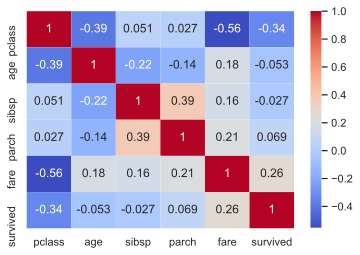

In [6]:
# correlation between target and features
X_comb = pd.concat([X_train, y_train.astype(float)], axis=1)
g = sns.heatmap(
    X_comb[['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'survived']].corr(),
    annot=True, 
    cmap = "coolwarm"
)

### feature engineering

In [7]:
# df['FamilySize'] = df['Parch'] + df['SibSp']
# df['IsAlone'] = df['FamilySize'].map(lambda x: 0 if x > 0 else 1)
# df['Title'] =  df['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
# df

In [8]:
class ExtractTitle(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, **transform_params):
        
        title_dict = {
            'Officer' : ['Capt', 'Col', 'Major', 'Dr', 'Rev'],
            'Royalty' : ['Jonkheer', 'Don', 'Sir', 'the Countess', 'Master', 'Lady'],
            'Miss' : ['Mlle'],
            'Mrs' : ['Mme']
        }
        inv_title_dict = { 
            val:key for key, vals in title_dict.items() for val in vals 
        }
  
        return pd.DataFrame(
            X["name"]
            .apply(lambda x: x.split(',')[1].split('.')[0].strip())
            .map(lambda x : inv_title_dict.get(x, x))
            .fillna("Mrs")
            .rename('title')
        )       

In [29]:
# data transformation pipeline

num_trans = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', RobustScaler())
])
  
cat_trans = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False)),
])

name_trans = Pipeline([
    ('name', ExtractTitle()), 
    ('cat', cat_trans)
]) 

preproc = ColumnTransformer([        
        ('numerical transfos', num_trans, ['age', 'fare', 'sibsp', 'parch']),
        ('categorical transfos', cat_trans, ['embarked', 'sex', 'pclass']),     
        ('name to title', name_trans, ['name']),
    ], remainder="drop",
)

In [30]:
# classifiers
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    NuSVC(probability=True),
    LogisticRegression(),
    MLPClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    ExtraTreesClassifier(), 
    GradientBoostingClassifier(),
    XGBClassifier() 
]

In [31]:
# running algos
for clf in classifiers:
    model = Pipeline([
        ('preprocessor', preproc),
        ('classifier', clf),
    ])
    model.fit(X_train, y_train)   
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy", n_jobs=-1)
    print(clf.__class__.__name__, '->', np.round(scores.mean(),4))

KNeighborsClassifier -> 0.7746
SVC -> 0.7297
NuSVC -> 0.808
LogisticRegression -> 0.809


C:\Users\Gege\Envs\ml\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier -> 0.8061
DecisionTreeClassifier -> 0.7612
RandomForestClassifier -> 0.787
AdaBoostClassifier -> 0.7879
ExtraTreesClassifier -> 0.7622
GradientBoostingClassifier -> 0.8137
[21:56:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Gege\Envs\ml\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier -> 0.7889


In [28]:
param_grid = [
    {        
        'classifier__bootstrap':[True], 
        'classifier__max_depth':[80], 
        'classifier__max_features':[2], 
        'classifier__min_samples_leaf':[4], 
        'classifier__min_samples_split':[10],
        'classifier__n_estimators':[100]
    },
]

#scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

# create the GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', refit=True) #verbose=3 

# fine-tune the hyperparameters
grid_search.fit(X_train, y_train)

# get the best model
final_model = grid_search.best_estimator_

# predict using the test dataset
test_predictions = final_model.predict(X_test)

accuracy = accuracy_score(y_test, test_predictions)
precision = precision_score(y_test, test_predictions)
recall = recall_score(y_test, test_predictions)
f1 = f1_score(y_test, test_predictions)
auc_roc = roc_auc_score(y_test, test_predictions)

print("accuracy_score = {a}, precision_score = {b}, recall_score = {c}, f1_score = {d}, AUC ROC = {e}"
      .format(a=accuracy, b=precision, c=recall, d=f1, e=auc_roc))

C:\Users\Gege\Envs\ml\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:55:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { bootstrap, max_features, min_samples_leaf, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:55:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Gege\Envs\ml\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:55:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { bootstrap, max_features, min_samples_leaf, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:55:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Gege\Envs\ml\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:55:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { bootstrap, max_features, min_samples_leaf, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:55:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Gege\Envs\ml\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:55:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { bootstrap, max_features, min_samples_leaf, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:55:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Gege\Envs\ml\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:55:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { bootstrap, max_features, min_samples_leaf, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:55:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Gege\Envs\ml\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:55:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { bootstrap, max_features, min_samples_leaf, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:55:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
accuracy_score = 0.7595419847328244, precision_score = 0.7032967032967034, recall_score = 0.64, f1_score = 0.6701570680628273, AUC ROC = 0.7366666666666668


In [358]:
y_scores = cross_val_predict(final_model, X_test, y_test, cv=5, method="predict_proba")

fpr, tpr, thresholds = roc_curve(y_test, y_scores[:, 1])

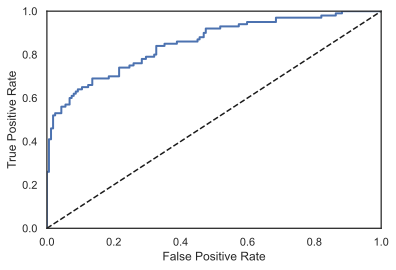

In [359]:
def plot_roc_curve( fpr, tpr, label = None): 
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([ 0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

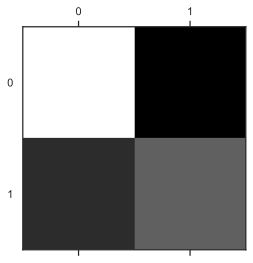

In [360]:
conf_mx = confusion_matrix(y_test, test_predictions)

plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

In [361]:
param_dist = {
    'preprocessor__nums__imputer__n_neighbors': list(range(2, 15)),
    'preprocessor__nums__imputer__add_indicator': [True, False],
    'preprocessor__cats__imputer__strategy': ['most_frequent', 'constant'],
    'preprocessor__cats__imputer__add_indicator': [True, False],
    'classifier__n_estimators': list(range(50, 500)),
    'classifier__max_features': ['auto', 'sqrt', 'log2'],
    'classifier__max_depth': list(range(2, 20)),
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    cv=5,
    n_iter=100,
    n_jobs=-1
)
random_search.fit(X_train, y_train)
print(random_search.best_score_)
print(random_search.best_params_)

0.8098792435634541
{'preprocessor__nums__imputer__n_neighbors': 6, 'preprocessor__nums__imputer__add_indicator': False, 'preprocessor__cats__imputer__strategy': 'most_frequent', 'preprocessor__cats__imputer__add_indicator': False, 'classifier__n_estimators': 414, 'classifier__max_features': 'auto', 'classifier__max_depth': 6, 'classifier__criterion': 'entropy', 'classifier__bootstrap': True}
